# EfficientSAM使用示例demo

In [33]:
import cv2
import torch
import zipfile
import os.path as osp
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import display, Image

from efficient_sam.build_efficient_sam import \
    build_efficient_sam_vitt, build_efficient_sam_vits

设置展示`蒙版`，`标点`，`标注框`函数

In [34]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

Build the EfficientSAM-Ti model.  
构建EfficientSAM-Ti和EfficientSAM-S 

In [35]:
models = {}

# Build the EfficientSAM-Ti model.
models['efficientsam_ti'] = build_efficient_sam_vitt()

with zipfile.ZipFile("weights/efficient_sam_vits.pt.zip", 'r') as zip_ref:
    zip_ref.extractall("weights")
# Build the EfficientSAM-S model.
models['efficientsam_s'] = build_efficient_sam_vits()


Load an image "figs/examples/dogs.jpg"  
载入示例图片

In [ ]:
example_img_path = 'figs/examples'
output_img_path = 'figs/outputs'

img_name = 'remu.png'

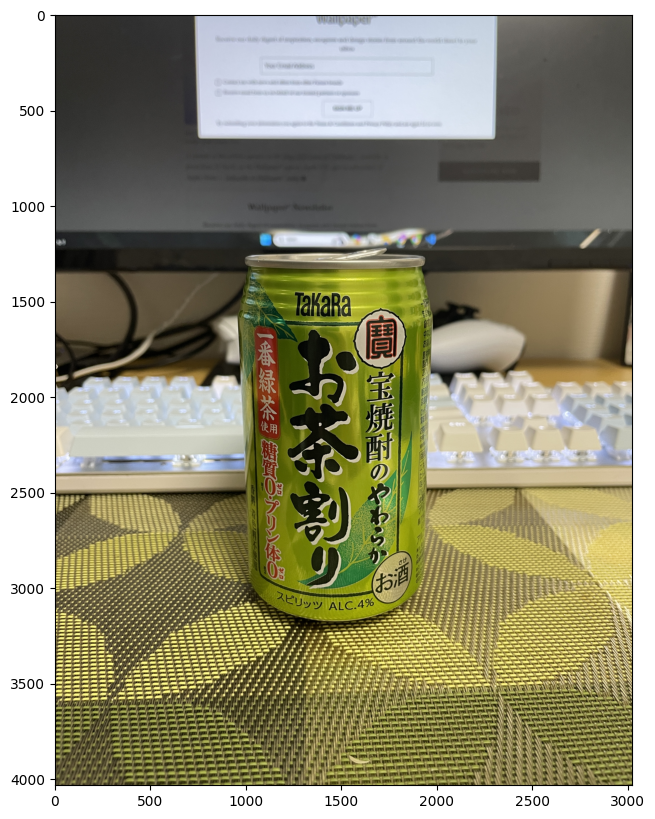

In [39]:
sample_image_np = cv2.imread(osp.join(example_img_path, img_name))
sample_image_np = cv2.cvtColor(sample_image_np, cv2.COLOR_BGR2RGB)
sample_image_tensor = transforms.ToTensor()(sample_image_np)

plt.figure(figsize=(10,10))
plt.imshow(sample_image_np)
plt.axis('on')
plt.show()


Feed a few (x,y) points in the mask as input.  
设置鼠标点击位置(x, y)为输入

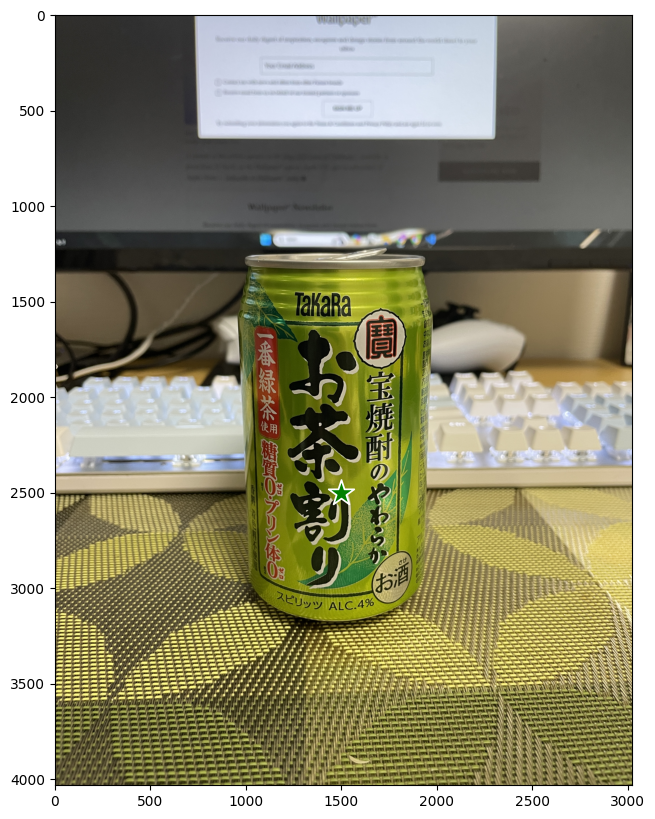

In [42]:
# Feed a few (x,y) points in the mask as input.
# input_points = torch.tensor([[[[520, 350], [650, 350]]]])
# input_labels = torch.tensor([[[1, 1]]])

input_points = torch.tensor([[[[1500, 2500]]]])
input_labels = torch.tensor([[[1]]])

plt.figure(figsize=(10,10))
plt.imshow(sample_image_np)
show_points(input_points.numpy(), input_labels.numpy(), plt.gca())
plt.axis('on')
plt.show()  

Run inference for both EfficientSAM-Ti and EfficientSAM-S models.  
对EfficientSAM-Ti和EfficientSAM-S模型进行推理

掩码已按其预测的IoU进行排序。
- 第一维是批处理大小（我们只有一张图像，所以是1）。
- 第二维是我们要生成的掩码数量（在这种情况下，只有1个）。
- 第三维是模型输出的候选掩码数量。
对于这个演示，我们使用第一个掩码。

In [43]:
# Run inference for both EfficientSAM-Ti and EfficientSAM-S models.
for model_name, model in models.items():
    print(f'使用{model_name}进行推理 ')
    predicted_logits, predicted_iou = model(
        sample_image_tensor[None, ...],
        input_points,
        input_labels,
    )
    sorted_ids = torch.argsort(predicted_iou, dim=-1, descending=True)
    predicted_iou = torch.take_along_dim(predicted_iou, sorted_ids, dim=2)
    predicted_logits = torch.take_along_dim(
        predicted_logits, sorted_ids[..., None, None], dim=2
    )
    mask = torch.ge(predicted_logits[0, 0, 0, :, :], 0).cpu().detach().numpy()
    
    # plt.figure(figsize=(10, 10))
    # plt.imshow(sample_image_np)
    # show_mask(mask, plt.gca())
    # show_points(input_points.numpy(), input_labels.numpy(), plt.gca())
    # plt.axis('off')
    # plt.show()
    
    # 保存为带有透明度的四通道BGRA格式：
    masked_image_np = sample_image_np.copy().astype(np.uint8)
    masked_image_np = cv2.cvtColor(masked_image_np, cv2.COLOR_RGB2BGRA)  # 转换为带有透明度的图像
    mask = np.where(mask, 255, 0).astype(np.uint8)
    masked_image_np[:,:,3] = mask  # 设置透明度

    # 保存结果为PNG格式
    cv2.imwrite(f"figs/examples/beer_{model_name}_mask_BGRA.png", masked_image_np)
    # masked_image_np = sample_image_np.copy().astype(np.uint8) * mask[:,:,None]
    

使用efficientsam_ti进行推理 
使用efficientsam_s进行推理 
